In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import json
import re
import seaborn as sns
import twitter_credentials
import matplotlib.pyplot as plt
from dateutil.parser import parse
from collections import Counter
from matplotlib.cbook import flatten

C:\Users\amerk\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    #most recent statuses
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    #most recent statuses, including retweets returns error 429 check again???
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_followers_list(self, num_tweets):
        followers_list = []
        for tweet in Cursor(self.twitter_client.followers, id=self.twitter_user).items(num_tweets):
            followers_list.append(tweet)
        return followers_list
    

# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)
        


# # # # TWITTER STREAM LISTENER # # # # 
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        #df['extended_entities'] = np.array([tweet.extended_entities for tweet in tweets])
        df['language'] = np.array([tweet.lang for tweet in tweets])
        df['is_reply'] = list(tweet.in_reply_to_status_id_str!=None for tweet in tweets)
        df['is_retweet'] = list(tweet.text.lower().startswith("rt @") == True for tweet in tweets)
        df['is_mention'] = np.array(~df['Tweets'].str.contains("RT")  
                                    & df['Tweets'].str.contains("@"))
        df['is_plain_text_tweets'] = np.array(~df['Tweets'].str.contains("@")  & ~df['Tweets'].str.contains("RT"))
        

        return df
    
    def streamed_tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet['full_text'] for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet['id'] for tweet in tweets])
        df['len'] = np.array([len(tweet['full_text']) for tweet in tweets])
        df['date'] = np.array([tweet['created_at'] for tweet in tweets])
        df['source'] = np.array([tweet['source'] for tweet in tweets])
        df['likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
        df['retweets'] = np.array([tweet['retweet_count'] for tweet in tweets])
        #df['extended_entities'] = np.array([tweet.extended_entities for tweet in tweets])
        df['language'] = np.array([tweet['lang'] for tweet in tweets])
        df['is_reply'] = list(tweet['in_reply_to_status_id_str']!=None for tweet in tweets)
        df['is_retweet'] = list(tweet['full_text'].lower().startswith("rt @") == True for tweet in tweets)
        df['is_mention'] = np.array(~df['Tweets'].str.contains("RT")  & df['Tweets'].str.contains("@"))
        df['is_plain_text_tweets'] = np.array(~df['Tweets'].str.contains("@")  & ~df['Tweets'].str.contains("RT"))
        

        return df
    
    def plt_layered_time_series(self, df):
        time_likes = pd.Series(data=df['likes'].values, index=pd.to_datetime(pd.Series(df["date"])))
        time_likes.plot(figsize=(16, 4), label="likes", legend=True)

        time_retweets = pd.Series(data=df['retweets'].values, index=pd.to_datetime(pd.Series(df["date"])))
        time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
        plt.savefig('layered_time_series.png', format='png')
        plt.show()
        
    #function to clean the tweets
    def cleanTxt(self, text):
        text = re.sub(r"(?:\@|#|https?\://)\S+", "", text)
        text = re.sub('[!@#$:").;,?&-]', '', text)
        text = re.sub('RT[\s]+', '', text) # Removing RT
        text = re.sub('  ', ' ', text)
    
        return text

    
        
    def world_cloud(self, df, file_name, color, stop_words = []):
        new_df = df.apply(self.cleanTxt).copy()
        text = ' '.join(txt for txt in new_df)
        stopwords = set(STOPWORDS)
        for word in stop_words:
            stopwords.add(word)
        #print ('There are {} words in the combination of text rows.'.format(len(text)))
        wordcloud = (WordCloud(background_color="white", # easier to read
                        max_words=50,colormap=color,stopwords=stopwords) 
                        .generate(text)) # generate the wordcloud with text
        plt.figure(figsize=(10,5)) # make the plot bigger
        # Show the plot (interpolation='bilinear' makes it better looking)
        plt.imshow(wordcloud, interpolation='bilinear') 
        plt.axis("off")
        plt.savefig(file_name + '.png', format='png', bbox_inches='tight')
        
    def plt_tweets_language_distribution(self, df):
        sns.countplot(df['language'])
        plt.savefig('tweets_language_distribution.png', format='png', bbox_inches='tight')
        plt.show()
        
    def plt_tweet_categories(self , df):
        len_list = [ len(df), len(df[df['is_retweet']== True]), len(df[df['is_mention']== True]), 
                    len(df[df['is_reply']== True]), len(df[df['is_plain_text_tweets']== True])]
        item_list = ['All Tweets','Retweets', 'Mentions', 'Replies', 'Plain text tweets']
        plt.xlabel('Type of tweet')
        plt.ylabel('Number of tweets')
        sns.barplot(x = item_list, y = len_list,  edgecolor = 'black', linewidth=1)
        plt.savefig('tweet_categories.png', format='png')
        plt.show()
        


#    def twitter_publishing_behavior(self, tweets):
#        tweets_text = []
#        contentType = []
#        for i in range(len(tweets)):
#            if tweets[i].full_text.lower().startswith("rt @") == True:
#                tweets_text.append(tweets[i].full_text)
#                if 'extended_entities' in tweets[i]._json['retweeted_status']:
#                    contentType.append(tweets[i]._json['retweeted_status']['extended_entities']['media'][0]['type'])
#                elif not tweets[i]._json['retweeted_status']['entities'].get("urls",[{}]):
#                    contentType.append('plain text')
#                else: contentType.append('link')
#            else: 
#                tweets_text.append(tweets[i].full_text)
#                if 'extended_entities' in tweets[i]._json:
#                    contentType.append(tweets[i]._json['extended_entities']['media'][0]['type'])
#                elif not tweets[i]._json['entities'].get("urls",[{}]):
#                    contentType.append('plain text')
#               else: contentType.append('link')
#                    
#        list_of_tuples = list(zip(tweets_text, contentType))
#        df1 = pd.DataFrame(list_of_tuples, columns = ['tweets_text', 'contentType'])
#        df1['date'] = np.array([tweet.created_at for tweet in tweets])
#        sns.countplot(df1['contentType'])
#        #plt.title('Twitter publishing behavior', fontsize = 20)
#        plt.xlabel('Type of publishing')
#        plt.ylabel('Total number')
#       plt.savefig('twitter_publishing_behavior.png', format='png')
#        plt.show()
  


    def twitter_publishing_behavior(self, tweets):
        tweets_text = []
        contentType = []
        for i in range(len(tweets)):
            if tweets[i]['full_text'].lower().startswith("rt @") == True:
                tweets_text.append(tweets[i]['full_text'])
                if 'extended_entities' in tweets[i]['retweeted_status']:
                    contentType.append(tweets[i]['retweeted_status']['extended_entities']['media'][0]['type'])
                elif not tweets[i]['retweeted_status']['entities'].get("urls",[{}]):
                    contentType.append('plain text')
                else: contentType.append('link')
            else: 
                tweets_text.append(tweets[i]['full_text'])
                if 'extended_entities' in tweets[i]:
                    contentType.append(tweets[i]['extended_entities']['media'][0]['type'])
                elif not tweets[i]['entities'].get("urls",[{}]):
                    contentType.append('plain text')
                else: contentType.append('link')
        list_of_tuples = list(zip(tweets_text, contentType))
        df1 = pd.DataFrame(list_of_tuples, columns = ['tweets_text', 'contentType'])
        df1['date'] = np.array([tweet['created_at'] for tweet in tweets])
        sns.countplot(df1['contentType'])
        plt.xlabel('Type of publishing')
        plt.ylabel('Total number')
        plt.savefig('twitter_publishing_behavior.png', format='png')
        plt.show()
        
    def avg_tweeting(self, df):
        first_timestamp = datetime.date(parse(df["date"].iloc[0]))
        last_timestamp = datetime.date(parse(df["date"].iloc[-1]))
        total_dt = (first_timestamp - last_timestamp).days
        mean = round(len(df) / total_dt, 2)
        print("Average tweeting rate between  %s and %s: %.2f tweets/day" % (first_timestamp, last_timestamp, mean))
        
    def count_used_hashtags(self, df):
        hashtag_pattern = re.compile(r"#[a-zA-Z]+")
        hashtag_matches = list(df['Tweets'].apply(hashtag_pattern.findall))
        hashtag_matches = list(flatten(hashtag_matches))
        df_new = pd.DataFrame.from_dict(Counter(hashtag_matches), orient='index').reset_index()
        df_new.rename(columns={'index':'hashtags', 0:'count'}, inplace = True)
        df_new.sort_values('count',inplace=True, ascending=False)
        return(df_new)
    
    def count_used_mentions(self, df):
        mentions = []
        mention_pattern = re.compile(r"@[a-zA-Z_]+")
        mention_matches = list(flatten(df['Tweets'].apply(mention_pattern.findall)))
        df_new = pd.DataFrame.from_dict(Counter(mention_matches), orient='index').reset_index()
        df_new.rename(columns={'index':'mentions', 0:'count'}, inplace = True)
        df_new.sort_values('count',inplace=True, ascending=False)
        return df_new
    

    

In [3]:
#hash_tag_list = ["Greta Thunberg"]
#fetched_tweets_filename = "tweets.txt"
#twitter_streamer = TwitterStreamer()
#twitter_streamer.stream_tweets(fetched_tweets_filename, hash_tag_list)

In [4]:
twitter_client = TwitterClient("GretaThunberg")
tweet_analyzer = TweetAnalyzer()
twitter_client.get_user_timeline_tweets
#tweets = twitter_client.get_user_timeline_tweets(10000)
api = twitter_client.get_twitter_client_api()
#tweetss = api.user_timeline(screen_name="GretaThunberg",tweet_mode='extended', count=200)
tweets = api.user_timeline(screen_name="GretaThunberg", count=10000)
#tweets = api.search(q="Greta Thunberg", tweet_mode='extended', count =100)
#df = tweet_analyzer.tweets_to_data_frame(tweets)

In [5]:
#tweets[3]._json

In [6]:
tweets_data = []
tweets_file =  open('data/time_line_tweets_full_text.txt', 'r')
for line in tweets_file:
    tweet = json.loads(line)
    tweets_data.append(tweet)

In [7]:
df = tweet_analyzer.streamed_tweets_to_data_frame(tweets_data)

In [8]:
tweet_analyzer.avg_tweeting(df)

Average tweeting rate between  2020-12-02 and 2020-10-22: 4.88 tweets/day


In [9]:
#df_lang = df.loc[:,['likes']]
#df_lang['likes'].value_counts().sort_values(ascending=False).head(10)

In [10]:
used_hashtags = tweet_analyzer.count_used_hashtags(df)
print("The total number of Tweets is:",len(tweets_data))
print("The most used hashtag is: %s" % (used_hashtags.iloc[0]['hashtags']))

The total number of Tweets is: 200
The most used hashtag is: #FridaysForFuture


In [11]:
used_mentions = tweet_analyzer.count_used_mentions(df)
print("The most used mention is: %s" % (used_mentions.iloc[0]['mentions']))

The most used mention is: @ScottDuncanWX


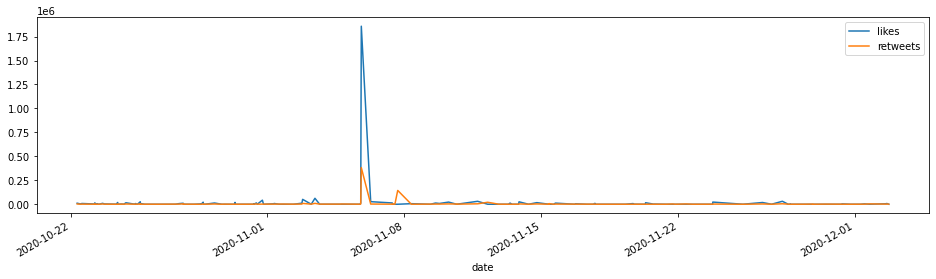

In [12]:
tweet_analyzer.plt_layered_time_series(df)

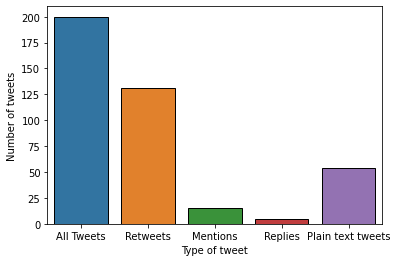

In [13]:
tweet_analyzer.plt_tweet_categories(df)

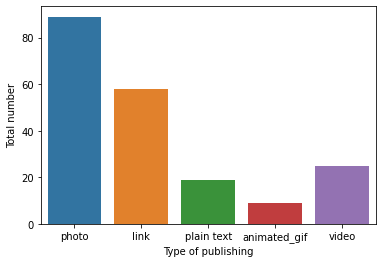

In [14]:
tweet_analyzer.twitter_publishing_behavior(tweets_data)

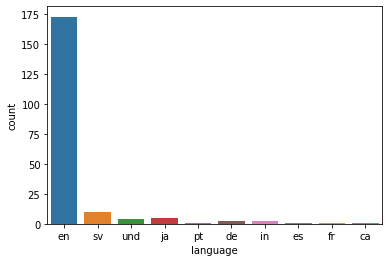

In [15]:
tweet_analyzer.plt_tweets_language_distribution(df)

In [16]:
#Most liked and shared tweet
df[df['retweets']==np.max(df['retweets'])]

,Tweets,id,len,date,source,likes,retweets,language,is_reply,is_retweet,is_mention,is_plain_text_tweets
105,So ridiculous. Donald must work on his Anger M...,1324439705522524162,162,Thu Nov 05 19:53:27 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",1858503,382205,en,False,False,False,True


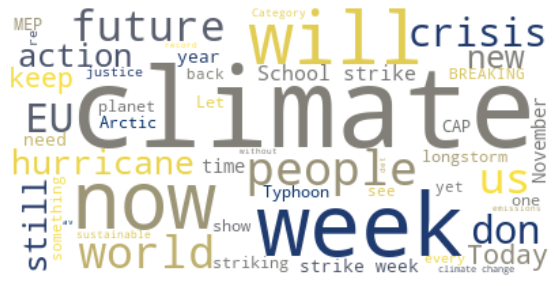

In [17]:
stop_words = ['de', 'att', 'och']
tweet_analyzer.world_cloud(df['Tweets'], 'world_cloud_Greta_full_text', 'cividis_r', stop_words)